## Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import xgboost as xgb
import keras
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

C:\Users\egusho\AppData\Local\Continuum\anaconda_3.0\envs\deep\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the data

In [2]:
prec = pd.read_csv('../data/MH25_vaisalawxt520prec_2017.csv')
wind = pd.read_csv('../data/MH25_vaisalawxt520windpth_2017.csv')
temp = pd.read_csv('../data/MH30_temperature_rock_2017.csv')
radio = pd.read_csv('../data/MH15_radiometer__conv_2017.csv')

## Merge the datasets

In [3]:
temp_inner = pd.merge(left= temp, right=prec, left_on='time',right_on='time')
temp_inner = pd.merge(left= temp_inner, right=wind, left_on='time',right_on='time')
temp_inner = pd.merge(left=temp_inner, right=radio, left_on='time',right_on='time')

## Select Columns

In [4]:
temp_inner['time'] = pd.to_datetime(temp_inner['time'])
temp_inner['season'] = np.round(pd.DatetimeIndex(temp_inner['time']).month/3)
del temp_inner['time']

temp_inner = temp_inner[['temperature_5cm [°C]', 'temperature_10cm [°C]',
       'temperature_20cm [°C]', 'temperature_30cm [°C]',
       'temperature_50cm [°C]', 'temperature_100cm [°C]',
       'wind_speed_average [km/h]', 'net_radiation [Wm^-2]', 'season']]


##  Create the target

In [5]:
lag = 1
diff = temp_inner['temperature_100cm [°C]'] - temp_inner['temperature_5cm [°C]']
temp_inner.insert(0, 'delta_t', diff)

# shift 
temp_inner['delta_t'] = temp_inner['delta_t'].shift(lag)
temp_inner = temp_inner.drop(temp_inner.index[0 : lag])
temp_inner = temp_inner.replace(np.nan, 0)
temp_inner.head()

,delta_t,temperature_5cm [°C],temperature_10cm [°C],temperature_20cm [°C],temperature_30cm [°C],temperature_50cm [°C],temperature_100cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season
1,2.3012,-9.5680,-9.2330,-8.8027,-8.4813,-7.9573,-7.2040,6.6033,-103.3083,0.0
2,2.3640,-9.6568,-9.3084,-8.8668,-8.5235,-7.9845,-7.2081,7.8323,-102.9365,0.0
3,2.4487,-9.7203,-9.3797,-8.9384,-8.5756,-8.0103,-7.2166,8.9094,-101.0145,0.0
4,2.5037,-9.7547,-9.4270,-8.9953,-8.6287,-8.0473,-7.2120,10.2742,-101.7435,0.0
5,2.5427,-9.7981,-9.4790,-9.0455,-8.6703,-8.0768,-7.2187,12.6367,-102.0387,0.0


## Train test split

In [6]:
X, y = temp_inner.drop(['delta_t'], axis=1), temp_inner['delta_t']

In [7]:
# split train and validation data
validation_fraction = 0.2
validation_first = False


val_size = int(validation_fraction * X.shape[0])
train_size = X.shape[0] - val_size

if validation_first:
    X_train, X_val = Y[val_size:], X[:val_size]
    y_train, y_val = y[val_size:], y[:val_size]
    
else:
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]


## Data Standartization

In [8]:
#Y_MEAN, Y_STD = y_train.mean(), y_train.std()

#y_train = (y_train - Y_MEAN)/Y_STD
#y_val   = (y_val -   Y_MEAN)/Y_STD
#X_MEAN, X_STD = X_train.mean(), X_train.std()
#X_train = (X_train - X_MEAN)/X_STD
#X_val = (X_val - X_MEAN)/X_STD

In [9]:
input_shape = X_train.shape
n_units = 80
n_layers = 3
n_frames = 5 # length of autoregressive sequence

## Define the LSTM model

In [10]:
from keras import layers, models
i = layers.Input(shape = (n_frames, 9)) # (?, n_frames, channels) 

# add the lstm layers
x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(i) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=False)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
#n_units *= 2            

#x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Activation('relu')(x)

o = layers.Dense(1, activation = 'linear')(x)  

In [11]:
model = models.Model(inputs=[i], outputs=[o])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 9)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 80)             28800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 160)            154240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 320)            615680    
_________________________________________________________________
lstm_4 (LSTM)                (None, 640)               2460160   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               82048     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
__________

In [13]:
from keras import optimizers, losses, metrics
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=losses.mse)
              #metrics=[metrics.mse])

In [14]:
from keras import utils
class SequenceGenerator(utils.Sequence):
    '''Generates image sequences'''

    def __init__(self, data, labels, batch_size=32, n_frames=5):
        '''Initialization'''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''

        batch_x, batch_y = [], []

        for _ in range(self.batch_size):
            # Get start index of sequence
            start_index = np.random.randint(0, len(self.data) - self.n_frames)
            stop_index = start_index + self.n_frames

            # x = image sequence
            x = self.data[start_index:stop_index].values
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        return batch_x, batch_y


In [15]:
batch_size = 120
n_epochs = 20
generator_train = SequenceGenerator(data = X_train, labels = y_train, batch_size = batch_size, n_frames = n_frames)
generator_test = SequenceGenerator(data = X_val, labels = y_val, batch_size = batch_size, n_frames = n_frames)

## Train the model

In [16]:
history = model.fit_generator(generator = generator_train,
                              steps_per_epoch = len(X_train)//batch_size,
                              epochs = n_epochs)

Epoch 1/20
58/58 [==============================] - 33s 570ms/step - loss: 2.4974
Epoch 2/20
58/58 [==============================] - 30s 525ms/step - loss: 0.7047
Epoch 3/20
58/58 [==============================] - 30s 513ms/step - loss: 0.2475
Epoch 4/20
58/58 [==============================] - 30s 522ms/step - loss: 0.1860
Epoch 5/20
58/58 [==============================] - 30s 517ms/step - loss: 0.1223
Epoch 6/20
58/58 [==============================] - 33s 569ms/step - loss: 0.1154
Epoch 7/20
58/58 [==============================] - 31s 539ms/step - loss: 0.0881
Epoch 8/20
58/58 [==============================] - 30s 519ms/step - loss: 0.0703
Epoch 9/20
58/58 [==============================] - 30s 521ms/step - loss: 0.0576
Epoch 10/20
58/58 [==============================] - 30s 520ms/step - loss: 0.0649
Epoch 11/20
58/58 [==============================] - 30s 511ms/step - loss: 0.0444
Epoch 12/20
58/58 [==============================] - 30s 516ms/step - loss: 0.0398
Epoch 13/20
5

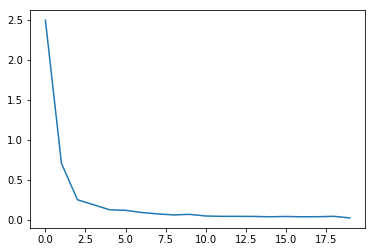

In [17]:
plt.plot(history.history['loss'])

## Test on validation set

In [18]:
predictions = []
y_truth = []
for t in range(0, len(X_val)-n_frames):
    start_index = t
    stop_index = start_index + n_frames
    data = X_val[start_index : stop_index].values
    data = data[np.newaxis, ...]
    p = np.asscalar(model.predict( data))
    # p = p * y_std + y_mean
    predictions.append(p)
    y_truth.append(y_val.iloc[stop_index])

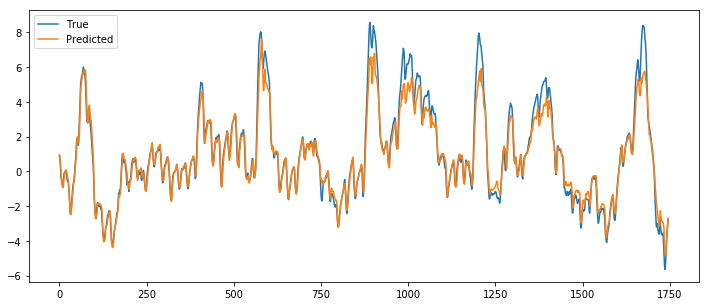

In [19]:
pd.concat([pd.DataFrame(y_truth, columns=['True']), 
           pd.DataFrame(predictions, columns = ["Predicted"])], axis = 1).plot(figsize=(12,5))